### Importing the Libraries

In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import torchvision.transforms as T
from torchvision import models
from torchvision import datasets
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 128
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#DEVICE = 'cpu'
DEVICE

device(type='cuda')

In [3]:
# Images are already in 48 X 48, so no need to resize
training_augs = T.Compose([
    T.Grayscale(num_output_channels=3),
    T.Resize((48, 48)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with mean=0.5 and std=0.5 (adjust for specific needs)
    T.RandomHorizontalFlip(),
    T.RandomAffine(degrees=0, shear=0.2, scale=(0.8, 1.2))
])


training_set = datasets.ImageFolder(root='jonathan_oheix/train', transform=training_augs)

training_loader = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)

In [4]:
valid_augs = T.Compose([
    T.Grayscale(num_output_channels=3),
    T.Resize((48, 48)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_set = datasets.ImageFolder(root='jonathan_oheix/validation', transform=valid_augs)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

In [5]:
print(training_set.class_to_idx)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [6]:
num_classes = len(training_set.classes)  # Number of emotion labels

# Load pretrained ResNet-50
model = models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT)

# Replace the last fully connected layer
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Send the model to GPU if available
cnn = model.to(DEVICE)

In [7]:
print(cnn)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [8]:
summary(cnn, input_size=(3, 48, 48), device=DEVICE.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 24, 24]           9,408
       BatchNorm2d-2           [-1, 64, 24, 24]             128
       BasicConv2d-3           [-1, 64, 24, 24]               0
         MaxPool2d-4           [-1, 64, 12, 12]               0
            Conv2d-5           [-1, 64, 12, 12]           4,096
       BatchNorm2d-6           [-1, 64, 12, 12]             128
       BasicConv2d-7           [-1, 64, 12, 12]               0
            Conv2d-8          [-1, 192, 12, 12]         110,592
       BatchNorm2d-9          [-1, 192, 12, 12]             384
      BasicConv2d-10          [-1, 192, 12, 12]               0
        MaxPool2d-11            [-1, 192, 6, 6]               0
           Conv2d-12             [-1, 64, 6, 6]          12,288
      BatchNorm2d-13             [-1, 64, 6, 6]             128
      BasicConv2d-14             [-1, 6

In [9]:
LR = 0.1
EPOCHS = 50

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [11]:
def multiclass_accuracy(y_pred,y_true):
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.cuda.FloatTensor))

In [12]:
def train_model(model, current_epoch, training_loader, optimizer, criterion, DEVICE):
    """
    Function to train the model for one epoch.
    """
    model.train()  # Set model to training mode
    running_loss = 0.0
    running_acc = 0.0
    tk = tqdm(training_loader, desc="EPOCH" + "[TRAIN]" + str(current_epoch + 1) + "/" + str(EPOCHS))
    
    for t, data in enumerate(tk):
        # Transfer images and labels to the specified device
        images, labels = data
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        # Prepare the data for input
        #train = Variable(images.view(images.size(0), 1, 48, 48))
        train = images
        labels = Variable(labels)

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(train)
        loss = criterion(outputs, labels)
        

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() # Total loss
        running_acc += multiclass_accuracy(outputs, labels)

        tk.set_postfix({'loss': '%6f' % float(running_loss / (t + 1)), 'acc': '%6f' % float(running_acc / (t + 1))})
    
    return running_loss / len(training_loader), running_acc / len(training_loader)

In [13]:
def test_model(model, current_epoch, test_loader, DEVICE):
    """
    Function to test the model and compute accuracy.
    """
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    predictions_list = []
    labels_list = []
    running_loss = 0.0
    running_acc = 0.0

    tk = tqdm(test_loader, desc="EPOCH" + "[VALID]" + str(current_epoch + 1) + "/" + str(EPOCHS))

    with torch.no_grad():  # Disable gradient calculation for testing
        for t, data in enumerate(tk):
            images, labels = data
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            labels_list.append(labels)

            #test = images.view(images.size(0), 1, 48, 48)
            test = images
            
            # Forward pass
            outputs = model(test)
            loss = criterion(outputs, labels)

            # Get predictions
            predictions = torch.max(outputs, 1)[1].to(DEVICE)
            predictions_list.append(predictions)
            correct += (predictions == labels).sum().item()
            total += len(labels)

            running_loss += loss.item()
            running_acc += multiclass_accuracy(outputs, labels)
            tk.set_postfix({'loss': '%6f' %float(running_loss / (t+1)), 'acc': '%6f' %float(running_acc / (t+1)), })

    #accuracy = 100 * correct / total
    return running_loss / len(test_loader), running_acc / len(test_loader), predictions_list, labels_list, 


In [14]:
# Reduce LR on Plateau
# Reduces the learning rate when a monitored metric (e.g., validation loss) stops improving.
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)


In [15]:
# Main training loop

# Dictionary to store loss values over epochs
metrics_loss = {
    'training_loss': [],
    'validation_loss': []
}
# Dictionary to store accuracy values over epochs
metrics_accuracy = {
    'training_accuracy': [],
    'validation_accuracy': []
}

iteration_list = []
count = 0
best_valid_loss = np.inf
patience_counter = 0   # Tracks the number of epochs without improvement
early_stop = False # Flag to indicate whether to stop training
patience = 6

for current_epoch in range(EPOCHS):
    if early_stop:
        print("Early stopping triggered. Stopping training.")
        break
    print(f"Epoch {current_epoch + 1}, LR: {scheduler.optimizer.param_groups[0]['lr']}")
    print("")
    
    # Training step
    train_loss, train_accuracy = train_model(cnn, current_epoch, training_loader, optimizer, criterion, DEVICE)
    
    # Increment count for iterations
    count += len(training_loader)

    valid_loss, valid_accuracy, predictions_list, labels_list,  = test_model(cnn, current_epoch, test_loader, DEVICE)

    # Record metrics
    metrics_loss['training_loss'].append(train_loss)
    metrics_loss['validation_loss'].append(valid_loss)

    metrics_accuracy['training_accuracy'].append(train_accuracy)
    metrics_accuracy['validation_accuracy'].append(valid_accuracy)

    iteration_list.append(count)

    # Update the learning rate based on validation loss and print
    scheduler.step(valid_loss)
    

    if valid_loss < best_valid_loss:
        torch.save(cnn.state_dict(), 'best_weights_googlenet_adam.pt')
        print("SAVED-BEST-WEIGHTS")
        best_valid_loss = valid_loss
        patience_counter = 0 # Reset early stopping
    else:
        patience_counter += 1
        print(f"No improvement in validation loss for {patience_counter} epoch(s).")

    if patience_counter >= patience:
        print("Patience exceeded. Early stopping at epoch " +str(current_epoch + 1))
        early_stop = True


Epoch 1, LR: 0.1



EPOCH[VALID]1/50: 100%|██████████| 56/56 [00:17<00:00,  3.11it/s, loss=2.005027, acc=0.258006]


SAVED-BEST-WEIGHTS
Epoch 2, LR: 0.1



EPOCH[VALID]2/50: 100%|██████████| 56/56 [00:14<00:00,  3.92it/s, loss=1.839896, acc=0.258714]


SAVED-BEST-WEIGHTS
Epoch 3, LR: 0.1



EPOCH[VALID]3/50: 100%|██████████| 56/56 [00:11<00:00,  4.74it/s, loss=1.820873, acc=0.257212]


SAVED-BEST-WEIGHTS
Epoch 4, LR: 0.1



EPOCH[VALID]4/50: 100%|██████████| 56/56 [00:11<00:00,  4.83it/s, loss=1.802780, acc=0.247242]


SAVED-BEST-WEIGHTS
Epoch 5, LR: 0.1



EPOCH[VALID]5/50: 100%|██████████| 56/56 [00:11<00:00,  4.80it/s, loss=1.801114, acc=0.259809]


SAVED-BEST-WEIGHTS
Epoch 6, LR: 0.1



EPOCH[VALID]6/50: 100%|██████████| 56/56 [00:11<00:00,  5.09it/s, loss=1.951594, acc=0.254153]


No improvement in validation loss for 1 epoch(s).
Epoch 7, LR: 0.1



EPOCH[VALID]7/50: 100%|██████████| 56/56 [00:11<00:00,  4.96it/s, loss=2.023258, acc=0.307413]


No improvement in validation loss for 2 epoch(s).
Epoch 8, LR: 0.1



EPOCH[VALID]8/50: 100%|██████████| 56/56 [00:12<00:00,  4.62it/s, loss=1.677763, acc=0.325077]


SAVED-BEST-WEIGHTS
Epoch 9, LR: 0.1



EPOCH[VALID]9/50: 100%|██████████| 56/56 [00:12<00:00,  4.45it/s, loss=1.787633, acc=0.344104]


No improvement in validation loss for 1 epoch(s).
Epoch 10, LR: 0.1



EPOCH[VALID]10/50: 100%|██████████| 56/56 [00:12<00:00,  4.34it/s, loss=1.635143, acc=0.343213]


SAVED-BEST-WEIGHTS
Epoch 11, LR: 0.1



EPOCH[VALID]11/50: 100%|██████████| 56/56 [00:13<00:00,  4.11it/s, loss=1.622268, acc=0.332793]


SAVED-BEST-WEIGHTS
Epoch 12, LR: 0.1



EPOCH[VALID]12/50: 100%|██████████| 56/56 [00:11<00:00,  4.74it/s, loss=1.533560, acc=0.397622]


SAVED-BEST-WEIGHTS
Epoch 13, LR: 0.1



EPOCH[VALID]13/50: 100%|██████████| 56/56 [00:11<00:00,  4.88it/s, loss=1.551785, acc=0.386150]


No improvement in validation loss for 1 epoch(s).
Epoch 14, LR: 0.1



EPOCH[VALID]14/50: 100%|██████████| 56/56 [00:12<00:00,  4.59it/s, loss=1.486530, acc=0.438316]


SAVED-BEST-WEIGHTS
Epoch 15, LR: 0.1



EPOCH[VALID]15/50: 100%|██████████| 56/56 [00:11<00:00,  4.76it/s, loss=1.429396, acc=0.426661]


SAVED-BEST-WEIGHTS
Epoch 16, LR: 0.1



EPOCH[VALID]16/50: 100%|██████████| 56/56 [00:12<00:00,  4.33it/s, loss=1.437056, acc=0.424697]


No improvement in validation loss for 1 epoch(s).
Epoch 17, LR: 0.1



EPOCH[VALID]17/50: 100%|██████████| 56/56 [00:12<00:00,  4.32it/s, loss=1.385512, acc=0.436985]


SAVED-BEST-WEIGHTS
Epoch 18, LR: 0.1



EPOCH[VALID]18/50: 100%|██████████| 56/56 [00:12<00:00,  4.47it/s, loss=1.411390, acc=0.435815]


No improvement in validation loss for 1 epoch(s).
Epoch 19, LR: 0.1



EPOCH[VALID]19/50: 100%|██████████| 56/56 [00:22<00:00,  2.53it/s, loss=1.453928, acc=0.421167]


No improvement in validation loss for 2 epoch(s).
Epoch 20, LR: 0.1



EPOCH[VALID]20/50: 100%|██████████| 56/56 [00:12<00:00,  4.52it/s, loss=1.449710, acc=0.395840]


No improvement in validation loss for 3 epoch(s).
Epoch 21, LR: 0.1



EPOCH[VALID]21/50: 100%|██████████| 56/56 [00:13<00:00,  4.13it/s, loss=1.377261, acc=0.440451]


SAVED-BEST-WEIGHTS
Epoch 22, LR: 0.1



EPOCH[VALID]22/50: 100%|██████████| 56/56 [00:13<00:00,  4.26it/s, loss=1.424551, acc=0.420888]


No improvement in validation loss for 1 epoch(s).
Epoch 23, LR: 0.1



EPOCH[VALID]23/50: 100%|██████████| 56/56 [00:13<00:00,  4.22it/s, loss=1.524278, acc=0.403803]


No improvement in validation loss for 2 epoch(s).
Epoch 24, LR: 0.1



EPOCH[VALID]24/50: 100%|██████████| 56/56 [00:21<00:00,  2.58it/s, loss=1.474463, acc=0.439056]


No improvement in validation loss for 3 epoch(s).
Epoch 25, LR: 0.1



EPOCH[VALID]25/50: 100%|██████████| 56/56 [00:13<00:00,  4.08it/s, loss=1.379504, acc=0.437124]


No improvement in validation loss for 4 epoch(s).
Epoch 26, LR: 0.010000000000000002



EPOCH[VALID]26/50: 100%|██████████| 56/56 [00:12<00:00,  4.31it/s, loss=1.265248, acc=0.508929]


SAVED-BEST-WEIGHTS
Epoch 27, LR: 0.010000000000000002



EPOCH[VALID]27/50: 100%|██████████| 56/56 [00:13<00:00,  4.12it/s, loss=1.255939, acc=0.512964]


SAVED-BEST-WEIGHTS
Epoch 28, LR: 0.010000000000000002



EPOCH[VALID]28/50: 100%|██████████| 56/56 [00:13<00:00,  4.14it/s, loss=1.249520, acc=0.512116]


SAVED-BEST-WEIGHTS
Epoch 29, LR: 0.010000000000000002



EPOCH[VALID]29/50: 100%|██████████| 56/56 [00:12<00:00,  4.43it/s, loss=1.252380, acc=0.516205]


No improvement in validation loss for 1 epoch(s).
Epoch 30, LR: 0.010000000000000002



EPOCH[VALID]30/50: 100%|██████████| 56/56 [00:13<00:00,  4.24it/s, loss=1.271390, acc=0.520798]


No improvement in validation loss for 2 epoch(s).
Epoch 31, LR: 0.010000000000000002



EPOCH[VALID]31/50: 100%|██████████| 56/56 [00:12<00:00,  4.43it/s, loss=1.240679, acc=0.524146]


SAVED-BEST-WEIGHTS
Epoch 32, LR: 0.010000000000000002



EPOCH[VALID]32/50: 100%|██████████| 56/56 [00:13<00:00,  4.03it/s, loss=1.242430, acc=0.524382]


No improvement in validation loss for 1 epoch(s).
Epoch 33, LR: 0.010000000000000002



EPOCH[VALID]33/50: 100%|██████████| 56/56 [00:12<00:00,  4.31it/s, loss=1.239143, acc=0.521055]


SAVED-BEST-WEIGHTS
Epoch 34, LR: 0.010000000000000002



EPOCH[VALID]34/50: 100%|██████████| 56/56 [00:12<00:00,  4.49it/s, loss=1.230159, acc=0.532216]


SAVED-BEST-WEIGHTS
Epoch 35, LR: 0.010000000000000002



EPOCH[VALID]35/50: 100%|██████████| 56/56 [00:13<00:00,  4.12it/s, loss=1.239345, acc=0.509615]


No improvement in validation loss for 1 epoch(s).
Epoch 36, LR: 0.010000000000000002



EPOCH[VALID]36/50: 100%|██████████| 56/56 [00:13<00:00,  4.26it/s, loss=1.221205, acc=0.531926]


SAVED-BEST-WEIGHTS
Epoch 37, LR: 0.010000000000000002



EPOCH[VALID]37/50: 100%|██████████| 56/56 [00:13<00:00,  4.21it/s, loss=1.253747, acc=0.544900]


No improvement in validation loss for 1 epoch(s).
Epoch 38, LR: 0.010000000000000002



EPOCH[VALID]38/50: 100%|██████████| 56/56 [00:13<00:00,  4.14it/s, loss=1.210247, acc=0.542700]


SAVED-BEST-WEIGHTS
Epoch 39, LR: 0.010000000000000002



EPOCH[VALID]39/50: 100%|██████████| 56/56 [00:13<00:00,  4.28it/s, loss=1.204879, acc=0.539084]


SAVED-BEST-WEIGHTS
Epoch 40, LR: 0.010000000000000002



EPOCH[VALID]40/50: 100%|██████████| 56/56 [00:13<00:00,  4.28it/s, loss=1.199982, acc=0.543784]


SAVED-BEST-WEIGHTS
Epoch 41, LR: 0.010000000000000002



EPOCH[VALID]41/50: 100%|██████████| 56/56 [00:15<00:00,  3.73it/s, loss=1.205755, acc=0.543827]


No improvement in validation loss for 1 epoch(s).
Epoch 42, LR: 0.010000000000000002



EPOCH[VALID]42/50: 100%|██████████| 56/56 [00:13<00:00,  4.06it/s, loss=1.208787, acc=0.549504]


No improvement in validation loss for 2 epoch(s).
Epoch 43, LR: 0.010000000000000002



EPOCH[VALID]43/50: 100%|██████████| 56/56 [00:14<00:00,  3.75it/s, loss=1.240822, acc=0.549654]


No improvement in validation loss for 3 epoch(s).
Epoch 44, LR: 0.010000000000000002



EPOCH[VALID]44/50: 100%|██████████| 56/56 [00:13<00:00,  4.27it/s, loss=1.197090, acc=0.544257]


SAVED-BEST-WEIGHTS
Epoch 45, LR: 0.010000000000000002



EPOCH[VALID]45/50: 100%|██████████| 56/56 [00:16<00:00,  3.37it/s, loss=1.222215, acc=0.548721]


No improvement in validation loss for 1 epoch(s).
Epoch 46, LR: 0.010000000000000002



EPOCH[VALID]46/50: 100%|██████████| 56/56 [00:12<00:00,  4.61it/s, loss=1.183024, acc=0.556222]


SAVED-BEST-WEIGHTS
Epoch 47, LR: 0.010000000000000002



EPOCH[VALID]47/50: 100%|██████████| 56/56 [00:13<00:00,  4.28it/s, loss=1.194165, acc=0.554688]


No improvement in validation loss for 1 epoch(s).
Epoch 48, LR: 0.010000000000000002



EPOCH[VALID]48/50: 100%|██████████| 56/56 [00:13<00:00,  4.21it/s, loss=1.168719, acc=0.565279]


SAVED-BEST-WEIGHTS
Epoch 49, LR: 0.010000000000000002



EPOCH[VALID]49/50: 100%|██████████| 56/56 [00:14<00:00,  3.81it/s, loss=1.166701, acc=0.569025]


SAVED-BEST-WEIGHTS
Epoch 50, LR: 0.010000000000000002



EPOCH[VALID]50/50: 100%|██████████| 56/56 [00:15<00:00,  3.71it/s, loss=1.157564, acc=0.572137]


SAVED-BEST-WEIGHTS


In [16]:
import importlib
import visualization_plots

In [17]:
importlib.reload(visualization_plots)

<module 'visualization_plots' from 'c:\\Python_Codes\\cpe520\\visualization_plots.py'>

### SGD Optimizer

#### ROC Curve

#### Plot of Accuracy over epochs

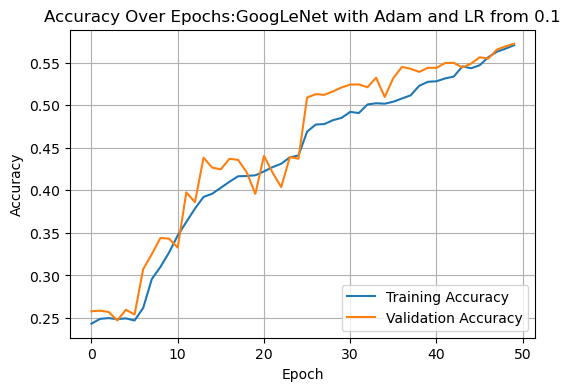

In [18]:
visualization_plots.plot_accuracy(metrics_accuracy, model_extra_desc="GoogLeNet with Adam and LR from 0.1")

#### Plot of Loss over epochs

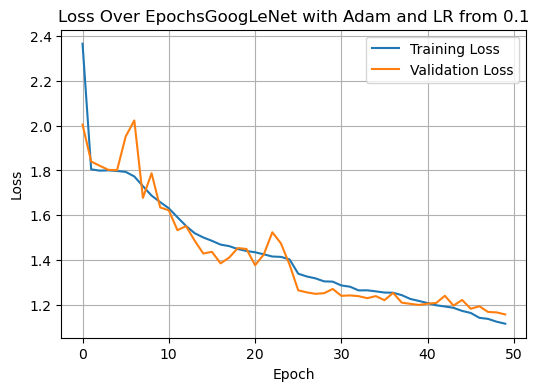

In [19]:
visualization_plots.plot_loss(metrics_loss, model_extra_desc="GoogLeNet with Adam and LR from 0.1")

#### Looking at the Accuracy in each class of dataset

In [20]:
label_classes = training_set.class_to_idx
# Switch keys and values
label_classes = {value: key for key, value in label_classes.items()}
label_classes

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

In [21]:
class_correct = [0. for _ in range(num_classes)]
total_correct = [0. for _ in range(num_classes)]

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        test = images
        outputs = cnn(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(num_classes):
    if total_correct[i] > 0:  # Avoid division by zero
        accuracy = class_correct[i] * 100 / total_correct[i]
        print(f"Accuracy of {label_classes[i]}: {accuracy:.3f}%")
    else:
        print(f"Accuracy of {label_classes[i]}: No samples")

Accuracy of angry: 37.604%
Accuracy of disgust: 0.000%
Accuracy of fear: 21.218%
Accuracy of happy: 83.836%
Accuracy of neutral: 53.207%
Accuracy of sad: 58.736%
Accuracy of surprise: 79.172%


#### Multipicture prediction plot